In [1]:
!pip install facenet-pytorch minisom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from google.colab import drive
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from minisom import MiniSom

from google.colab import drive

drive.mount('/content/drive')
!unzip -q "/content/drive/MyDrive/datasets.zip" -d "/content/datasets"
!cp "/content/drive/MyDrive/final_resnet50_amp_7.pth" "/content/final_resnet50_amp_7.pth"
# Remove Contempt
!mkdir '/content/separated_dataset'
!mkdir '/content/separated_test_dataset'
!mv '/content/datasets/separated_dataset/7' '/content/separated_dataset/7'
!mv '/content/datasets/separated_test_dataset/7' '/content/separated_test_dataset/7'

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

data_dir = '/content/datasets/separated_dataset'
test_data_dir = '/content/datasets/separated_test_dataset'

# transform and class weights
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
targets = full_dataset.targets

print("Classes:", full_dataset.classes)
num_classes = len(full_dataset.classes)

train_indices, val_indices = train_test_split(
    np.arange(len(targets)),
    test_size=0.05,
    random_state=seed,
    stratify=targets
)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

test_dataset = datasets.ImageFolder(root=test_data_dir, transform=data_transforms)
print(f"Test size: {len(test_dataset)}")

targets = [label for _, label in full_dataset.samples]
class_counts = Counter(targets)
total_samples = len(targets)

weights = []
for i in range(num_classes):
    class_count = class_counts[i]
    weight = total_samples / (num_classes * class_count)
    weights.append(weight)

weights = torch.tensor(weights, dtype=torch.float32)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


num_emotions = num_classes

backbone = InceptionResnetV1(pretrained='vggface2', classify=False)
backbone.classify = False

class InceptionResnetV1EmotionClassification(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        emb = self.backbone(x)
        logits = self.classifier(emb)
        return logits

model = InceptionResnetV1EmotionClassification(backbone, num_emotions).to(device)
weights = weights.to(device)

#weights_model = ResNet50_Weights.DEFAULT
#model = resnet50(weights=weights_model)
#model.fc = nn.Sequential(
#    nn.Linear(model.fc.in_features, 256),
#    nn.ReLU(),
#    nn.Dropout(0.5),
#    nn.Linear(256, num_classes)
#)
#model.to(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/datasets/separated_dataset/0/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
mkdir: cannot create directory ‘/content/separated_dataset’: File exists
mkdir: cannot create directory ‘/content/separated_test_dataset’: File exists
Classes: ['0', '1', '2', '3', '4', '5', '6']
Train size: 269705, Val size: 14196
Test size: 3500


In [17]:
def compute_per_class_acc(model, dataloader, device, num_classes):
    model.eval()
    correct = torch.zeros(num_classes)
    total   = torch.zeros(num_classes)

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            preds = torch.argmax(logits, dim=1)

            for l, p in zip(labels, preds):
                total[l] += 1
                if l == p:
                    correct[l] += 1

    per_class_acc = correct / total.clamp(min=1)
    return per_class_acc.cpu()


In [18]:
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #0,00005
scaler = torch.cuda.amp.GradScaler()

batch_size = 64
num_workers = 2

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())

In [19]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
num_epochs = 40 #20
subset_fraction = 0.1

best_macro_avg = 0.0
best_model_path = "best_macro_model.pth"

for epoch in range(num_epochs):
    subset_size = max(1, int(len(train_dataset) * subset_fraction))
    indices = random.sample(range(len(train_dataset)), subset_size)
    subset_epoch_dataset = Subset(train_dataset, indices)
    subset_loader = DataLoader(subset_epoch_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=torch.cuda.is_available())

    # train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in subset_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f}")

    # val
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f}\n")

    # after each epoch on val_loader
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    report = classification_report(
        all_labels, all_preds,
        target_names=full_dataset.classes,
        output_dict=True
    )

    print(report)

    macro_f1 = report['macro avg']['f1-score']

    if macro_f1 > best_macro_avg:
        best_macro_avg = macro_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1}, macro_avg Acc: {best_macro_avg:.4f}")

Epoch 1/40 - Train Loss: 1.6869 - Train Acc: 0.5879
Epoch 1/40 - Val Loss: 1.4382 - Val Acc: 0.6629

{'0': {'precision': 0.6186058174523571, 'recall': 0.6589209401709402, 'f1-score': 0.6381272633212622, 'support': 3744.0}, '1': {'precision': 0.9450395083406496, 'recall': 0.8007736943907157, 'f1-score': 0.8669458762886598, 'support': 6721.0}, '2': {'precision': 0.3742437337942956, 'recall': 0.3401413982717989, 'f1-score': 0.3563786008230453, 'support': 1273.0}, '3': {'precision': 0.24815724815724816, 'recall': 0.14326241134751774, 'f1-score': 0.18165467625899281, 'support': 705.0}, '4': {'precision': 0.21818181818181817, 'recall': 0.6394984326018809, 'f1-score': 0.3253588516746411, 'support': 319.0}, '5': {'precision': 0.12857142857142856, 'recall': 0.04736842105263158, 'f1-score': 0.06923076923076923, 'support': 190.0}, '6': {'precision': 0.419238683127572, 'recall': 0.655144694533762, 'f1-score': 0.5112923462986199, 'support': 1244.0}, 'accuracy': 0.6629332206255283, 'macro avg': {'pr

In [20]:
model_save_path = "inceptionResnet50_stratified_40.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Final model saved to {model_save_path}")

Final model saved to inceptionResnet50_stratified_40.pth


Test Loss: 1.1158 - Test Acc: 0.6069
{'0': {'precision': 0.5123152709359606, 'recall': 0.624, 'f1-score': 0.5626690712353472, 'support': 500.0}, '1': {'precision': 0.8007736943907157, 'recall': 0.828, 'f1-score': 0.8141592920353983, 'support': 500.0}, '2': {'precision': 0.6436781609195402, 'recall': 0.56, 'f1-score': 0.5989304812834224, 'support': 500.0}, '3': {'precision': 0.5302013422818792, 'recall': 0.632, 'f1-score': 0.5766423357664233, 'support': 500.0}, '4': {'precision': 0.6659142212189616, 'recall': 0.59, 'f1-score': 0.6256627783669141, 'support': 500.0}, '5': {'precision': 0.6622516556291391, 'recall': 0.4, 'f1-score': 0.49875311720698257, 'support': 500.0}, '6': {'precision': 0.5133779264214047, 'recall': 0.614, 'f1-score': 0.5591985428051002, 'support': 500.0}, 'accuracy': 0.6068571428571429, 'macro avg': {'precision': 0.6183588959710858, 'recall': 0.6068571428571429, 'f1-score': 0.6051450883856554, 'support': 3500.0}, 'weighted avg': {'precision': 0.6183588959710858, 'reca

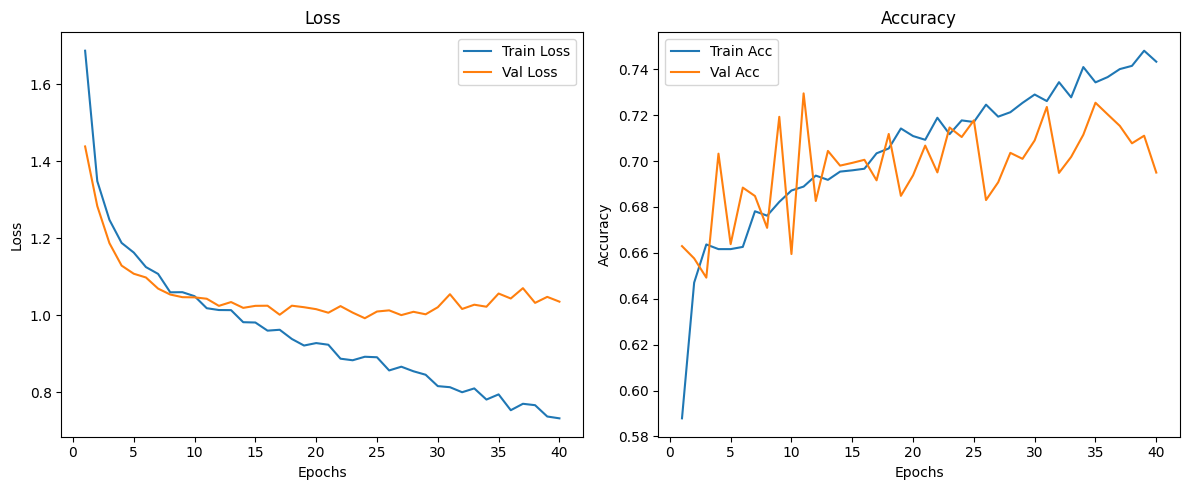

              precision    recall  f1-score   support

           0       0.51      0.62      0.56       500
           1       0.80      0.83      0.81       500
           2       0.64      0.56      0.60       500
           3       0.53      0.63      0.58       500
           4       0.67      0.59      0.63       500
           5       0.66      0.40      0.50       500
           6       0.51      0.61      0.56       500

    accuracy                           0.61      3500
   macro avg       0.62      0.61      0.61      3500
weighted avg       0.62      0.61      0.61      3500

Confusion matrix:
 [[312  21  47  55   8  10  47]
 [ 38 414   2  33   2   8   3]
 [ 83   8 280  30  30  16  53]
 [ 45  27  10 316  71  13  18]
 [ 22  10  33  93 295  20  27]
 [ 40  31  38  30  18 200 143]
 [ 69   6  25  39  19  35 307]]


In [21]:
model.load_state_dict(torch.load(model_save_path)) #best_model_path
model.to(device)
model.eval()

all_preds = []
all_labels = []

test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

print(f"Test Loss: {test_loss/test_total:.4f} - Test Acc: {test_correct/test_total:.4f}")

print(classification_report(
        all_labels, all_preds,
        target_names=full_dataset.classes,
        output_dict=True
    ))

epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Acc')
plt.plot(epochs_range, val_accuracies, label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

print(classification_report(all_labels, all_preds, digits=2))
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)

In [ ]:
model_load_path = "final_resnet50_amp_7.pth"
model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))
model.to(device)

In [7]:
model.eval()

class FeatureExtractor(torch.nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.features = torch.nn.Sequential(*list(backbone.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

feature_extractor = FeatureExtractor(model).to(device)

In [8]:
all_feats = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        feats = feature_extractor(inputs)
        all_feats.append(feats.cpu().numpy())
        all_labels.append(labels.numpy())

X = np.concatenate(all_feats, axis=0)
y = np.concatenate(all_labels, axis=0)
feature_dim = X.shape[1]

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Feature matrix shape: (3500, 2048)
Labels shape: (3500,)


In [13]:
som_rows, som_cols = 8, 8
som = MiniSom(
    x=som_rows,
    y=som_cols,
    input_len=feature_dim,
    sigma=1.0,
    learning_rate=0.5,
    neighborhood_function='gaussian',
    random_seed=42
)

som.random_weights_init(X)
print("Training SOM...")
som.train_random(X, num_iteration=5000)
print("SOM training done.")

Training SOM...
SOM training done.


In [14]:
num_classes = len(full_dataset.classes)
bmu_class_counts = np.zeros((som_rows, som_cols, num_classes), dtype=int)

for feat, label in zip(X, y):
    i, j = som.winner(feat)
    bmu_class_counts[i, j, label] += 1

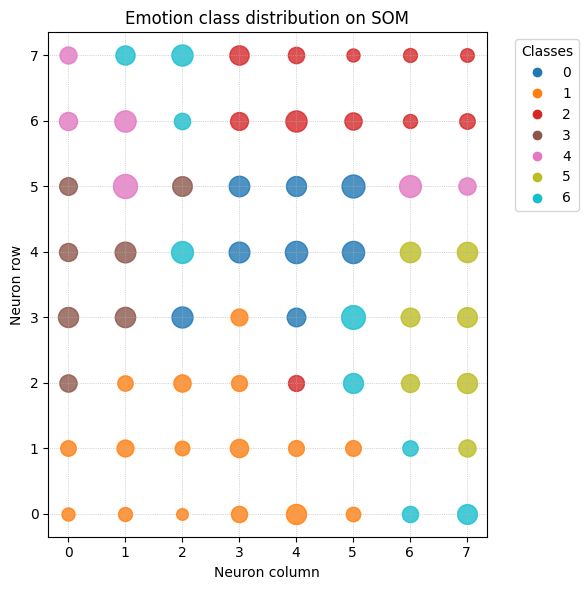

In [15]:
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

max_total = bmu_class_counts.sum(axis=2).max()
class_names = full_dataset.classes

plt.figure(figsize=(6, 6))

for i in range(som_rows):
    for j in range(som_cols):
        class_counts = bmu_class_counts[i, j]
        total = class_counts.sum()
        if total == 0:
            continue

        majority_class = np.argmax(class_counts)
        majority_count = class_counts[majority_class]

        size = 50 + 250 * (total / max_total)

        plt.scatter(
            j,
            som_rows - 1 - i,
            s=size,
            c=[colors[majority_class]],
            alpha=0.8
        )

plt.xticks(range(som_cols))
plt.yticks(range(som_rows))
plt.grid(True, linestyle=":", linewidth=0.5)
plt.xlabel("Neuron column")
plt.ylabel("Neuron row")
plt.title("Emotion class distribution on SOM")

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               color=colors[k], label=class_names[k])
    for k in range(num_classes)
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")

plt.tight_layout()
plt.show()